# 1.) Import an asset price from Yahoo Finance

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
#### Kellog starting on Aug 1, 1985 ####

stock_data = yf.download("K", start="1985-08-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [ ]:
# Create x_train and y_train data
x_train = []
y_train = []
input_size = 10

for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    if train_data[i, 0] > 0:
        y_train.append(1)
    else:
        y_train.append(0)

# Convert to numpy arrays and reshape for LSTM input
x_train = np.array(x_train)
y_train = np.array(y_train)
print("Shapes before reshaping:", x_train.shape, y_train.shape)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("Shapes after reshaping:", x_train.shape, y_train.shape)

# Build an RNN Architecture
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)


Shapes before reshaping: (7360, 10) (7360,)
Shapes after reshaping: (7360, 10, 1) (7360,)
Epoch 1/3
7360/7360 [==============================] - 62s 7ms/step - loss: 0.2504 - accuracy: 0.5031
Epoch 2/3
7360/7360 [==============================] - 53s 7ms/step - loss: 0.2501 - accuracy: 0.5053
Epoch 3/3
7360/7360 [==============================] - 51s 7ms/step - loss: 0.2499 - accuracy: 0.5111


In [ ]:
#Epoch 1, 2, and 3 each recorded accuracies around ~50%

In [ ]:
import pandas as pd

# Compute the percentage change in the asset price
pct_change_data = pd.DataFrame(scaled_data).pct_change().values[1:]
pct_change_data

array([[ 0.99099099],
       [-3.22991071],
       [ 0.58744622],
       ...,
       [ 0.69162056],
       [-2.93402196],
       [ 1.34643652]])

In [ ]:
# Compute the binary variable y
y = (pct_change_data[:, 0] > 0).astype(int)
y = y[1:]  # Remove the first row, which has no corresponding y value

# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [ ]:

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))




predictions = model.predict(x_test)



58/58 [==============================] - 3s 7ms/step


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the training data
scaler.fit(train_data)


# Invert the scaling for the predictions and actual prices
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


In [ ]:
# Random Walk
# Did it go up yesterday? And will it go up today

y_test[1:] # Actual
y_test[:-1] # Prediction

# OOS Random walk model
y_test[1:] # Actual
y_test[:-1] # Prediction

array([[-0.2616229 ],
       [-0.25769216],
       [-0.26513553],
       ...,
       [-0.26414284],
       [-0.26499494],
       [-0.25888002]])

In [ ]:
#Making predictions on the test data

predictions = model.predict(x_test)
predictions = (predictions > 0.5)

58/58 [==============================] - 0s 5ms/step


In [ ]:
#Calculating in-sample accuracy
from sklearn.metrics import accuracy_score


train_predictions = model.predict(x_train)
train_predictions = (train_predictions > 0.5)
in_sample_acc = accuracy_score(y_train, train_predictions)

230/230 [==============================] - 1s 5ms/step


In [ ]:
#Calculating in-sample random walk assumption accuracy

y_train_rw = np.roll(y_train, 1)
y_train_rw[0] = 0
in_sample_rw_acc = accuracy_score(y_train, y_train_rw)

In [ ]:
#Calculating out-of-sample accuracy
from sklearn.metrics import mean_squared_error


# Make predictions on the test data
predictions = model.predict(x_test)

# Invert the scaling for the predictions and actual prices
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the MSE
mse = mean_squared_error(y_test, predictions)
print('MSE:', mse)

58/58 [==============================] - 0s 5ms/step
MSE: 0.1345004475855685


In [ ]:



# Computing the out-of-sample random walk assumption accuracy using MAE and RMSE
y_test_rw = np.roll(y_test, 1)
y_test_rw[0] = 0

mae_rw = np.mean(np.abs(y_test - y_test_rw))
rmse_rw = np.sqrt(np.mean(np.square(y_test - y_test_rw)))

print('Out-of-sample RW assumption MAE:', mae_rw)
print('Out-of-sample RW assumption RMSE:', rmse_rw)

Out-of-sample RW assumption MAE: 0.0035754918358778007
Out-of-sample RW assumption RMSE: 0.010337945251247524


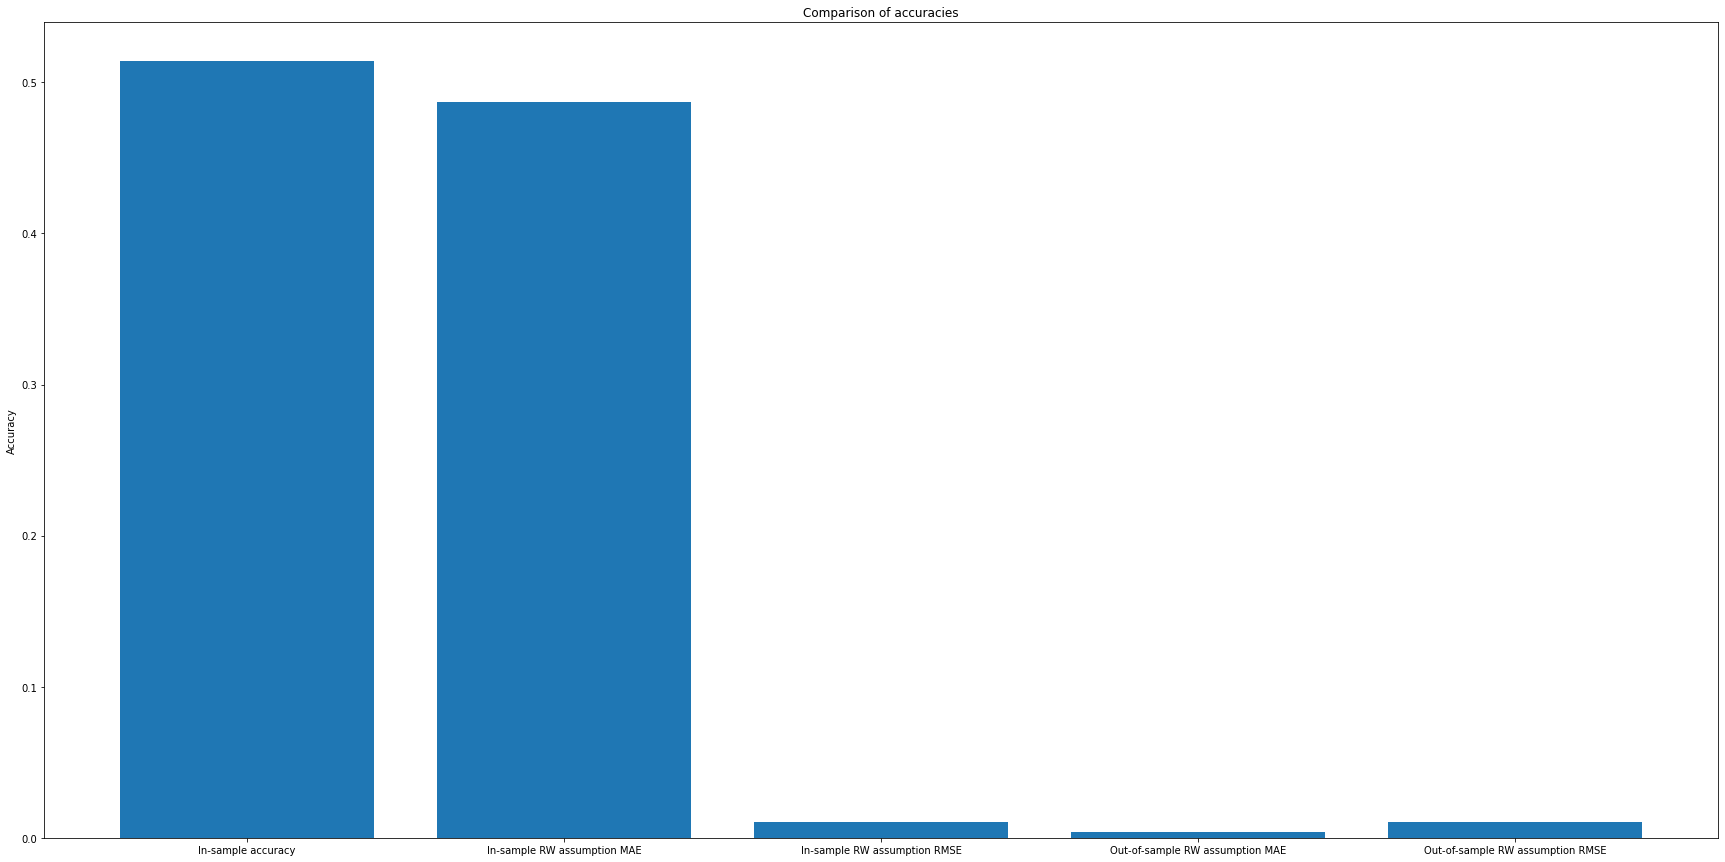

In [ ]:
import matplotlib.pyplot as plt

# in-sample accuracy
_, in_sample_acc = model.evaluate(x_train, y_train, verbose=0)


#  out-of-sample accuracy
out_sample_acc = model.evaluate(x_test, y_test, verbose=0)[1]

#  out-of-sample random walk assumption accuracy using MAE and RMSE
y_test_rw = np.roll(y_test, 1)
y_test_rw[0] = 0

mae_rw_test = np.mean(np.abs(y_test - y_test_rw))
rmse_rw_test = np.sqrt(np.mean(np.square(y_test - y_test_rw)))

# Finally, a bar chart to compare the accuracies
labels = ['In-sample accuracy', 'In-sample RW assumption MAE', 'In-sample RW assumption RMSE',
          'Out-of-sample RW assumption MAE', 'Out-of-sample RW assumption RMSE']
values = [in_sample_acc, in_sample_rw_acc, rmse_rw, mae_rw, rmse_rw_test]

plt.figure(figsize=(30, 15))
plt.bar(labels, values)
plt.title('Comparison of accuracies')
plt.ylabel('Accuracy')
plt.show()


## DONT DO 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

In [ ]:
# The in-sample accuracy (RNN) and in-sample Random Walk (RW) accuracy are both quite low, around 51%. 
## This suggests that the model is likely unable to effectively capture the patterns in the data (Kellog stock) and make accurate predictions in the future

# The in-sample random walk assumption RMSE, has a value of ~0.01 -- and is lower than the  out-of-sample random walk assumption (RMSE).
## This suggests that the model is overfitting to the training data and not generalizing well to new data.

# In conclusion, the results tell me that my model likely needs  further tuning or a different approach to predict the behavior of Kellog (K) stock.


# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
import numpy as np



# Define the length of the sliding window
window_length = 5

# Calculate the number of samples that can be created from the data using the window length
n_samples = stock_data.shape[0] - window_length + 1

# Create an empty array to hold the sliding window data
sliding_window_data = np.empty((n_samples, window_length, stock_data.shape[1]))

# Populate the sliding window data array by iterating over the original data
for i in range(n_samples):
    sliding_window_data[i] = stock_data[i:i+window_length]

# Now the sliding window data array has shape (220196, 5, 10), which can be reshaped to (220196, 50)
sliding_window_data = sliding_window_data.reshape((n_samples, -1))


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, LSTM, TimeDistributed
from keras.models import Sequential

def create_model(lags):
    model = Sequential()
    model.add(LSTM(10, input_shape=(lags, 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
param_grid = {'lags': [5, 10, 20],
              'batch_size': [10, 20, 100],
              'epochs': [1]}


In [ ]:
model = KerasRegressor(build_fn=lambda lags: create_model(lags=lags), verbose=0)

<ipython-input-86-6e7977793596>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=lambda lags: create_model(lags=lags), verbose=0)


In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__auto

Best: -0.693330 using {'batch_size': 10, 'epochs': 1, 'lags': 10}


In [ ]:
## Best: -0.693330 using {'batch_size': 10, 'epochs': 1, 'lags': 10}